# Example of access to DC2 Run 1.1p data and some analysis

DC2 will contain a large amount of data and the resources at NERSC offer a unique opportunity to analyze these data.

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import glob

In [3]:
import lsst.daf.persistence

In [4]:
import GCRCatalogs

`GCRCatalogs` contains information about the input galaxies for DC2 so we are going to use it as truth table. Note that this is just an approximation!

In [5]:
import healpy as hp

In [6]:
from sklearn.neighbors import KDTree
from lsst.sims.utils import cartesianFromSpherical, sphericalFromCartesian, rotationMatrixFromVectors

protoDC2_v2 and DC2 Run 1.1p are not centered on the same coordinates so we are going to rotate the field using the code from GCR_simsinterface

In [7]:
def rotate(ra0,dec0,ra1,dec1,ra,dec):
    #Code from GCR_simsinterface
    xyz = cartesianFromSpherical(np.radians(ra0), np.radians(dec0))
    xyz1 = cartesianFromSpherical(np.radians(ra1), np.radians(dec1))
    if np.abs(1.0-np.dot(xyz, xyz1))<1.0e-10:
        transformation = np.identity(3, dtype=float)
    
    first_rotation = rotationMatrixFromVectors(xyz, xyz1)
    xx = np.dot(first_rotation, xyz)
    rng = np.random.RandomState(99)
    mag = np.NaN
    while np.abs(mag)<1.0e-20 or np.isnan(mag):
        random_vec = rng.random_sample(3)
        comp = np.dot(random_vec, xx)
        yy = random_vec - comp*xx
        mag = np.sqrt((yy**2).sum())
        yy /= mag
    zz = np.cross(xx, yy)
    to_self_bases = np.array([xx,
                          yy,
                          zz])

    out_of_self_bases =to_self_bases.transpose()
    d_dec = 0.1
    north = cartesianFromSpherical(np.radians(ra0),
                                    np.radians(dec0+d_dec))
    north = np.dot(first_rotation, north)
    north_true = cartesianFromSpherical(np.radians(ra1),
                                        np.radians(dec1+d_dec))

    north = np.dot(to_self_bases, north)
    north_true = np.dot(to_self_bases, north_true)
    north = np.array([north[1], north[2]])
    north /= np.sqrt((north**2).sum())
    north_true = np.array([north_true[1], north_true[2]])
    north_true /= np.sqrt((north_true**2).sum())

    c = north_true[0]*north[0]+north_true[1]*north[1]
    s = north[0]*north_true[1]-north[1]*north_true[0]
    norm = np.sqrt(c*c+s*s)
    c = c/norm
    s = s/norm

    nprime = np.array([c*north[0]-s*north[1],
                        s*north[0]+c*north[1]])

    yz_rotation = np.array([[1.0, 0.0, 0.0],
                            [0.0, c, -s],
                            [0.0, s, c]])

    second_rotation = np.dot(out_of_self_bases,
                                np.dot(yz_rotation,
                                    to_self_bases))

    transformation = np.dot(second_rotation,
                                first_rotation)
    xyz = cartesianFromSpherical(np.radians(ra), np.radians(dec)).transpose()
    xyz = np.dot(transformation, xyz).transpose()
    ra_out, dec_out = sphericalFromCartesian(xyz)
    return np.degrees(ra_out), np.degrees(dec_out)


Path of the processed 1.1p tests at NERSC

In [8]:
data_path = '/global/projecta/projectdirs/lsst/global/in2p3/Run1.1-test2/output'

Let's call the Butler

In [9]:
butler = lsst.daf.persistence.Butler(data_path)

Let's check some numbers

In [10]:
datarefs = butler.subset('calexp')

We have ~10,000 single visits

We use protoDC2 to match inputs and outputs

In [11]:
gc = GCRCatalogs.load_catalog('proto-dc2_v2.1.2')

In [12]:
data = gc.get_quantities(['mag_true_u_lsst', 'mag_true_g_lsst','mag_true_r_lsst', 'mag_true_i_lsst', 'mag_true_z_lsst', 'mag_true_Y_lsst', 'redshift', 'ra', 'dec','galaxy_id'])

For protoDC2_v2 the field wasn't rotated yet!

In [13]:
ra_new, dec_new = rotate(0.,0.,55.064,-29.783,data['ra'],data['dec'])

We build a KDTree to make spatial matching

In [14]:
X = np.zeros((len(data['ra']),2))
X[:,0]=ra_new
X[:,1]=dec_new
tree = KDTree(X)

Let's select one visit (or several)

In [15]:
ra_aux = []
dec_aux = []
nchild = []
mag = []
mag_err = []
for i, visitId in enumerate(datarefs.cache[:1215]):
    if visitId['filter']=='r':
        print(i,visitId)
        src_cat = butler.get('src',visitId)
        calexp = butler.get('calexp',visitId)
        calib = calexp.getCalib()
        calib.setThrowOnNegativeFlux(False)
        nchild.append(src_cat.get('deblend_nChild'))
        ra_aux.append(np.degrees(src_cat.get('coord_ra')))
        dec_aux.append(np.degrees(src_cat.get('coord_dec')))
        mag.append(calib.getMagnitude(src_cat.get('ext_photometryKron_KronFlux_flux')))
        mag_err.append(calib.getMagnitude(src_cat.get('ext_photometryKron_KronFlux_fluxSigma')))

1199 {'visit': 181898, 'filter': 'r', 'raft': '2,0', 'sensor': '0,0'}
1200 {'visit': 181898, 'filter': 'r', 'raft': '2,1', 'sensor': '0,0'}
1201 {'visit': 181898, 'filter': 'r', 'raft': '2,2', 'sensor': '0,0'}
1202 {'visit': 181898, 'filter': 'r', 'raft': '2,3', 'sensor': '0,0'}
1203 {'visit': 181898, 'filter': 'r', 'raft': '2,4', 'sensor': '0,0'}
1204 {'visit': 181898, 'filter': 'r', 'raft': '3,0', 'sensor': '0,0'}
1205 {'visit': 181898, 'filter': 'r', 'raft': '3,1', 'sensor': '0,0'}
1206 {'visit': 181898, 'filter': 'r', 'raft': '3,2', 'sensor': '0,0'}
1207 {'visit': 181898, 'filter': 'r', 'raft': '3,3', 'sensor': '0,0'}
1208 {'visit': 181898, 'filter': 'r', 'raft': '3,4', 'sensor': '0,0'}
1209 {'visit': 181898, 'filter': 'r', 'raft': '4,1', 'sensor': '0,0'}
1210 {'visit': 181898, 'filter': 'r', 'raft': '4,2', 'sensor': '0,0'}
1211 {'visit': 181898, 'filter': 'r', 'raft': '4,3', 'sensor': '0,0'}
1212 {'visit': 181898, 'filter': 'r', 'raft': '2,0', 'sensor': '0,1'}
1213 {'visit': 18189

In [16]:
src_cat.getSchema()

Schema(
    (Field['L'](name="id", doc="unique ID"), Key<L>(offset=0, nElements=1)),
    (Field['Angle'](name="coord_ra", doc="position in ra/dec"), Key<Angle>(offset=8, nElements=1)),
    (Field['Angle'](name="coord_dec", doc="position in ra/dec"), Key<Angle>(offset=16, nElements=1)),
    (Field['L'](name="parent", doc="unique ID of parent source"), Key<L>(offset=24, nElements=1)),
    (Field['Flag'](name="calib_detected", doc="Source was detected as an icSource"), Key['Flag'](offset=32, bit=0)),
    (Field['Flag'](name="calib_psfCandidate", doc="Flag set if the source was a candidate for PSF determination, as determined by the star selector."), Key['Flag'](offset=32, bit=1)),
    (Field['Flag'](name="calib_psfUsed", doc="Flag set if the source was actually used for PSF determination, as determined by the"), Key['Flag'](offset=32, bit=2)),
    (Field['Flag'](name="calib_psf_reserved", doc="set if source was reserved from PSF determination"), Key['Flag'](offset=32, bit=3)),
    (Field[

In [17]:
nchild = np.concatenate(np.array(nchild)).ravel()
mag = np.concatenate(np.array(mag)).ravel()
ra_aux = np.concatenate(np.array(ra_aux)).ravel()
dec_aux = np.concatenate(np.array(dec_aux)).ravel()
mag_err = np.concatenate(np.array(mag_err)).ravel()

In [18]:
X2 = np.zeros((np.count_nonzero(nchild==0),2))
X2[:,0] = ra_aux[nchild==0]
X2[:,1] = dec_aux[nchild==0]
dist, ind = tree.query(X2)
ind = ind.flatten()

Some plots showing the difference between output and matched magnitudes

(-1, 1)

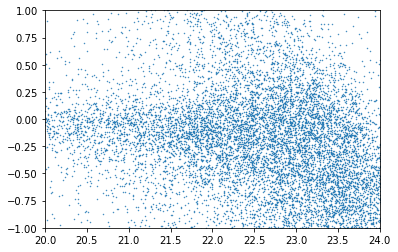

In [19]:
plt.scatter(data['mag_true_r_lsst'][ind],mag[nchild==0]-data['mag_true_r_lsst'][ind],s=0.2)
plt.xlim(20,24)
plt.ylim(-1,1)

(20, 24)

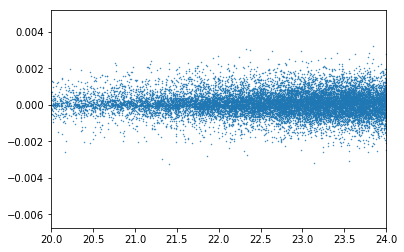

In [20]:
plt.scatter(data['mag_true_r_lsst'][ind],ra_aux[nchild==0]-ra_new[ind],s=0.2)
plt.xlim(20,24)

In [21]:
patches_paths = glob.glob('/global/projecta/projectdirs/lsst/global/in2p3/Run1.1-test2/output/deepCoadd-results/r/4848/*')

In [22]:
tracts = [4430,4432]#,4638,4640,4849,4851,5062,5064,5066,4431,4637,4639,4848,4850,4852,5063,5065]

What columns does the catalog contain?

In [23]:
magmodel=np.zeros(0)
ra_coadd=np.zeros(0)
dec_coadd=np.zeros(0)
isprimary=np.zeros(0,dtype=bool)
nchild_coadd=np.zeros(0,dtype=int)
psfmag=np.zeros(0)
magmodel_err=np.zeros(0)
psfmag_err=np.zeros(0)
blendedness=np.zeros(0)
modelflux=np.zeros(0)
modelflux_err=np.zeros(0)
psfflux=np.zeros(0)
psfflux_err=np.zeros(0)
extendedness=np.zeros(0)
for tract in tracts:
    patches_paths = glob.glob('/global/projecta/projectdirs/lsst/global/in2p3/Run1.1-test2/output/deepCoadd-results/r/'+str(tract)+'/*')
    patches = [pp[-3:] for pp in patches_paths]
    for patch in patches:
        try:
            cat = butler.get('deepCoadd_meas',filter='r',tract=tract,patch=patch)
            calib = lsst.afw.image.Calib(butler.get('deepCoadd_md',filter='r',tract=tract,patch=patch))
            calib.setThrowOnNegativeFlux(False)
            ra_coadd = np.concatenate([ra_coadd,cat.get('coord_ra')]).ravel()
            dec_coadd = np.concatenate([dec_coadd,cat.get('coord_dec')]).ravel()
            magmodel= np.concatenate([magmodel,calib.getMagnitude(cat.get('modelfit_CModel_flux'))])
            magmodel_err=np.concatenate([magmodel_err,calib.getMagnitude(cat.get('modelfit_CModel_fluxSigma'))])
            psfmag=np.concatenate([psfmag,calib.getMagnitude(cat.get('base_PsfFlux_flux'))])
            psfmag_err=np.concatenate([psfmag_err,calib.getMagnitude(cat.get('base_PsfFlux_fluxSigma'))])
            isprimary=np.concatenate([isprimary,cat.get('detect_isPrimary')])
            blendedness=np.concatenate([blendedness,cat.get('base_Blendedness_old')])
            nchild_coadd=np.concatenate([nchild_coadd,cat.get('deblend_nChild')])
            modelflux=np.concatenate([modelflux,cat.get('modelfit_CModel_flux')])
            modelflux_err=np.concatenate([modelflux_err,cat.get('modelfit_CModel_fluxSigma')])
            psfflux=np.concatenate([psfflux,cat.get('base_PsfFlux_flux')])
            psfflux_err=np.concatenate([psfflux_err,cat.get('base_PsfFlux_fluxSigma')])
            extendedness=np.concatenate([extendedness,cat.get('base_ClassificationExtendedness_value')])
        except:
            continue

In [24]:
X2 = np.zeros((np.count_nonzero(isprimary),2))
X2[:,0] = np.degrees(ra_coadd[isprimary])
X2[:,1] = np.degrees(dec_coadd[isprimary])
dist, ind = tree.query(X2)
ind = ind.flatten()

/global/common/software/lsst/common/miniconda/py3-4.3.21/lib/python3.6/site-packages/numpy/lib/function_base.py:973: RuntimeWarning: invalid value encountered in greater_equal
  not_smaller_than_edge = (sample[:, i] >= edges[i][-1])


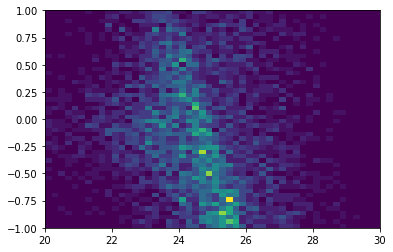

In [25]:
plt.hist2d(data['mag_true_r_lsst'][ind],magmodel[isprimary]-data['mag_true_r_lsst'][ind],range=[(20,30),(-1,1)],bins=50);

In [26]:
def depth_map_snr(ra,dec,mags,snr,nside=2048):
    good = np.logical_or(np.logical_not(np.isnan(ra)),np.logical_not(np.isnan(dec)))
    pix_nums = hp.ang2pix(nside,np.pi/2.-dec[good]*np.pi/180,ra[good]*np.pi/180)
    map_out = np.zeros(12*nside**2)
    #Binned statistic 2d is awfully slow (because it doesn't use the fact that all bins are equal width
    #median_snr, xed, _, _ = binned_statistic_2d(mags,pix_nums,snr,statistic='median',bins=(50,12*nside**2),range=[(20,30),(0,12*nside**2)])
    #bin_centers = 0.5*xed[1:]+0.5*xed[:-1]
    #depth = bin_centers[np.argmin(np.fabs(median_snr-5),axis=0)]
    map_out = np.zeros(12*nside**2)
    bin_centers = np.linspace(22+6/30.,28-6/30.,30.)
    for px in np.unique(pix_nums):
        mask = px==pix_nums
        if np.count_nonzero(mask)>0:
            median_snr = binned_statistic(mags[mask],snr[mask],np.nanmedian,nbins=30,range=(22,28))
            mask2 = np.isnan(median_snr)==False
            if np.count_nonzero(mask2)>0:
                depth = bin_centers[mask2][np.argmin(np.fabs(median_snr[mask2]-5.))]
                map_out[px]=depth
            else:
                map_out[px]=0
        else:
            map_out[px]=0.
    return map_out


In [27]:
def binned_statistic(x, values, func, nbins, range):
    '''The usage is approximately the same as the scipy one
    from https://stackoverflow.com/questions/26783719/effic
    iently-get-indices-of-histogram-bins-in-python'''
    from scipy.sparse import csr_matrix
    r0, r1 = range
    mask = (x > r0) &  (x < r1)
    x = x[mask]
    values = values[mask]
    N = len(values)
    digitized = (float(nbins) / (r1-r0) * (x-r0)).astype(int)
    S = csr_matrix((values, [digitized, np.arange(N)]), shape=(nbins, N))
    return np.array([func(group) for group in np.split(S.data, S.indptr[1:-1])])

In [28]:
m5map = depth_map_snr(np.degrees(ra_coadd[isprimary]),np.degrees(dec_coadd[isprimary]),
                         magmodel[isprimary],modelflux[isprimary]/modelflux_err[isprimary])

/global/common/software/lsst/common/miniconda/py3-4.3.21/lib/python3.6/site-packages/ipykernel/__main__.py:10: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
/global/common/software/lsst/common/miniconda/py3-4.3.21/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:990: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/global/common/software/lsst/common/miniconda/py3-4.3.21/lib/python3.6/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in greater
/global/common/software/lsst/common/miniconda/py3-4.3.21/lib/python3.6/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in less


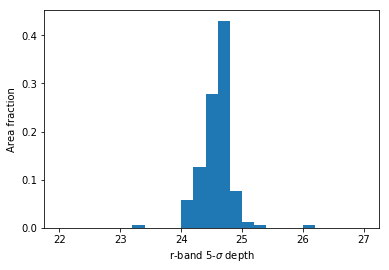

In [29]:
plt.hist(m5map[m5map!=0],weights=np.ones(np.count_nonzero(m5map[m5map!=0]))/np.count_nonzero(m5map[m5map!=0]),bins=25,range=(22,27))
plt.xlabel(r'r-band 5-$\sigma$ depth')
plt.ylabel('Area fraction')

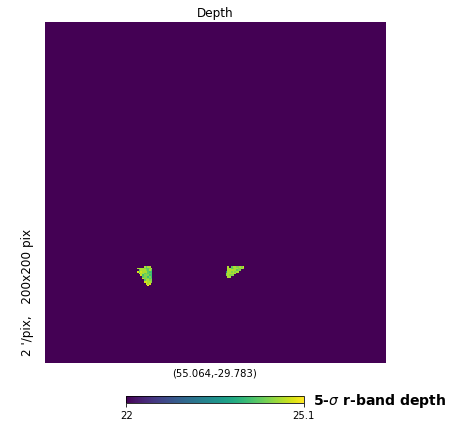

In [30]:
hp.gnomview(m5map,rot=(55.064,-29.783), title='Depth', reso=2.0,unit='5-$\sigma$ r-band depth',min=22)

In [ ]:
#m5map=hp.write_map('/global/projecta/projectdirs/lsst/groups/LSS/DC2_R1.1p/depth_coadd_r.fits.gz',m5map)

In [31]:
import astropy.table

In [32]:
tab_data = astropy.table.Table([ra_coadd,dec_coadd,magmodel,magmodel_err,psfmag,psfmag_err,
                                modelflux,modelflux_err,psfflux,psfflux_err,blendedness,isprimary,nchild_coadd,extendedness],
                              names=('ra','dec','magmodel','magmodel_err','psfmag','psfmag_err','modelflux','modelflux_err',
                                    'psfflux','psfflux_err','blendedness','isprimary','nchild','extendedness'))

We can save an load the results (please do not overwrite/erase the files)

In [ ]:
#tab_data.write('catalog_r1p1.fits.gz',overwrite=True)
tab_data = astropy.table.Table.read('/global/projecta/projectdirs/lsst/groups/LSS/DC2_R1.1p/catalog_r1p1.fits.gz')

(array([   301.,   2742.,   3208.,   4033.,   7110.,   4370.,   6314.,
          8054.,  10432.,   7532.]),
 array([ 0.01647048,  0.11584118,  0.21521189,  0.31458259,  0.4139533 ,
         0.513324  ,  0.61269471,  0.71206541,  0.81143612,  0.91080682,
         1.01017753]),
 <a list of 10 Patch objects>)

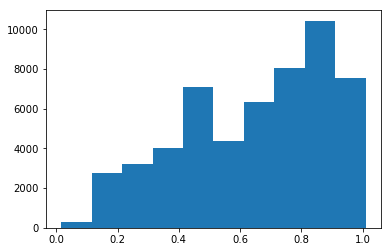

In [33]:
plt.hist(data['redshift'][ind])

In [34]:
nz, ze = np.histogram(data['redshift'][ind])

In [ ]:
#tab_z = astropy.table.Table([0.5*(ze[1:]+ze[:-1]),nz],names=('z','Nz'))
#tab_z.write('/global/projecta/projectdirs/lsst/groups/LSS/DC2_R1.1p/nz_matched_r1p1p.fits.gz')